In [1]:
# Import Dependancies
import hvplot.pandas
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime



In [2]:
# Create a file path for the cleaned csv file
path = 'Cleaned_Crimes_-_2016_to_present.csv'

# Read csv file with pandas
cleaned_crime_data = pd.read_csv(path, encoding='ISO-8859-1')
cleaned_crime_data.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,0,25953,JE240540,05/24/2021 03:06:00 PM,020XX N LARAMIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,...,36.0,19.0,01A,1141387.0,1913179.0,2021,11/18/2023 03:39:49 PM,41.917838,-87.755969,"(41.917838056, -87.755968972)"
1,1,26038,JE279849,06/26/2021 09:24:00 AM,062XX N MC CORMICK RD,0110,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,True,...,50.0,13.0,01A,1152781.0,1941458.0,2021,11/18/2023 03:39:49 PM,41.995219,-87.713355,"(41.995219444, -87.713354912)"
2,2,13279676,JG507211,11/09/2023 07:30:00 AM,019XX W BYRON ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,...,47.0,5.0,05,1162518.0,1925906.0,2023,11/18/2023 03:39:49 PM,41.952345,-87.677975,"(41.952345086, -87.677975059)"
3,3,13274752,JG501049,11/12/2023 07:59:00 AM,086XX S COTTAGE GROVE AVE,0454,BATTERY,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",SMALL RETAIL STORE,True,...,6.0,44.0,08B,1183071.0,1847869.0,2023,12/09/2023 03:41:24 PM,41.737751,-87.604856,"(41.737750767, -87.604855911)"
4,4,13203321,JG415333,09/06/2023 05:00:00 PM,002XX N Wells st,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,...,42.0,32.0,14,1174694.0,1901831.0,2023,11/04/2023 03:40:18 PM,41.886018,-87.633938,"(41.886018055, -87.633937881)"


# New code by quinns_branch
## Plotting Hot Spots
#### Step 1: Find the value to search

In [3]:
# Group by 'Primary Type' and get the count of each primary type
top_4_crimes = cleaned_crime_data.groupby('Primary Type').size()

# Sort values in ascending order and reassign into a list to reference
top_4_crimes = top_4_crimes.sort_values(ascending=True)

# Get only the top 4 crimes
top_4_crimes = top_4_crimes[-4:]

# Convert the Series into a DataFrame and reset the index
top_4_crimes_df = top_4_crimes.reset_index(name='Total Incidents')

# Print the new DataFrame
print(f"You want to find a specific value, which is one of these options:")
top_4_crimes_df

You want to find a specific value, which is one of these options:


,Primary Type,Total Incidents
0,ASSAULT,179954
1,CRIMINAL DAMAGE,243963
2,BATTERY,402701
3,THEFT,489381


In [4]:
# Input the specific value you want to analyze
specific_value = 'assault' # You can capitalized the specific value if you want

# Define your Primary Type
prim_type = cleaned_crime_data[cleaned_crime_data['Primary Type'] == f'{specific_value.upper()}'].copy()  # ASSAULT is the specific value I want to find

#### Step 2: Start setting up plotting variables
Now, with both the specific value to search defined and the new filtered pandas DataFrame, we can start to work on getting datetime set up to follow Ian's brilliant code

In [5]:
# We need to convert 'Date' column to datetime format in the new, filtered dataframe
prim_type['Date'] = pd.to_datetime(prim_type['Date'], format='%m/%d/%Y %I:%M:%S %p')

In [6]:
# Borrowing Ian's code here
# Next, define pandemic periods
prim_type['Pandemic Period'] = pd.cut(
    prim_type['Date'],
    bins=[
        pd.Timestamp('2017-01-01'),
        pd.Timestamp('2020-01-31'),
        pd.Timestamp('2023-05-11'),

        # Added specific date of the last update for the dataset before downloading
        # Because the bins are exclusive, I made the date one day above the update date
        pd.Timestamp('2024-10-26'), 
    ],
    labels=['Before Pandemic', 'During Pandemic', 'After Pandemic'],

    # This makes the right edge of each bin exclusive which means the first bin will not include the secnod timestamp date.
    # It will only put in values that are up to that date. (example: bin 2 will group all dates from 2020-01-32 to 2023-05-10)
    right = False 
)
# Basic stats and summary by period
print(prim_type.info())
print(prim_type.groupby('Pandemic Period').size())

# Filter data for relevant columns
# Added the block column to count and define our hotspots
crime_location_data = prim_type[['Date', 'Primary Type', 'Block', 'Latitude', 'Longitude', 'Pandemic Period']].dropna()

crime_location_data = crime_location_data[
    (crime_location_data['Latitude'] != 0.0) & # Removes any undifined/missing latitude values
    (crime_location_data['Longitude'] != 0.0) & # Removes any undifined/missing longitude values
    (crime_location_data['Latitude'] > 37.0) # Removes unfortunate outlier
]

<class 'pandas.core.frame.DataFrame'>
Index: 179954 entries, 31 to 2171282
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            179954 non-null  int64         
 1   ID                    179954 non-null  int64         
 2   Case Number           179954 non-null  object        
 3   Date                  179954 non-null  datetime64[ns]
 4   Block                 179954 non-null  object        
 5   IUCR                  179954 non-null  object        
 6   Primary Type          179954 non-null  object        
 7   Description           179954 non-null  object        
 8   Location Description  179954 non-null  object        
 9   Arrest                179954 non-null  bool          
 10  Domestic              179954 non-null  bool          
 11  Beat                  179954 non-null  int64         
 12  District              179954 non-null  float64       
 13  Wa

C:\Users\qjone\AppData\Local\Temp\ipykernel_120600\784947239.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(prim_type.groupby('Pandemic Period').size())


In [34]:
# Define the order of the periods (so the output is printed in order)
period_order = ['Before Pandemic', 'During Pandemic', 'After Pandemic']

# Initialize a dictionary to store outlier values for each period
outliers_dict = {}

# Setting up a empty list for later plotting
all_incident_counts = []

# Loop through each period label in the defined order
for period in period_order:
    print(f"Analyzing data for {specific_value.lower()} incidents that occurred {period}\n")
    
    # Filter the data for the current period
    period_data = crime_location_data[crime_location_data['Pandemic Period'] == period]

    # Check the total of the unique value counts for each block during this period
    incident_counts = period_data['Block'].value_counts()
    
    # Remove all blocks with 0 incidents
    incident_counts = incident_counts[incident_counts > 0]

    # After this is calculated, add all those values into the empty list as a sub-list
    all_incident_counts.append(incident_counts.to_list())
    # with this line of code, I can now move the plotting code outside of the loop and plot each period in one chart at the end

    # Calculate Quartile Values for a Boxplot
    quartiles = incident_counts.quantile([0.25, 0.5, 0.75, 1.0])
    lowerq = quartiles[0.25]  # Lower quartile
    upperq = quartiles[0.75]  # Upper quartile
    iqr = upperq - lowerq     # Interquartile range

    # Calculate bounds for outliers
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)

    # Print combined output for quartile calculations
    print(
        f"The lower quartile of {specific_value.lower()} incidents is: {lowerq}\n"
        f"The upper quartile of {specific_value.lower()} incidents is: {upperq}\n"
        f"The interquartile range of {specific_value.lower()} incidents is: {iqr}\n"
        f"Values below {lower_bound} could be outliers.\n"
    )

    # Print combined output for ease of access to important information
    print(
        f"\nIMPORTANT:\n"
        f"\nThis is the outlier data, which we will need to calculate hot spots.\n"
        f"Thus, blocks with values above {upper_bound} are data points that we need to filter for."
    )
    
    # Input upper bound outlier values into a dictionary for each period
    outliers_dict[period] = upper_bound

    # Filter period data to keep only rows where the block incident counts are above the upper bound
    outlier_blocks = incident_counts[incident_counts > upper_bound].index
    period_outliers_df = period_data[period_data['Block'].isin(outlier_blocks)]

    # Uses period label to create a new df to store the new created outliers dataframe
    globals()[f"{period.replace(' ', '_')}_outliers_df"] = period_outliers_df

    print("="*75)  # Separator between different periods


Analyzing data for assault incidents that occurred Before Pandemic

The lower quartile of assault incidents is: 1.0
The upper quartile of assault incidents is: 4.0
The interquartile range of assault incidents is: 3.0
Values below -3.5 could be outliers.


IMPORTANT:

This is the outlier data, which we will need to calculate hot spots.
Thus, blocks with values above 8.5 are data points that we need to filter for.
Analyzing data for assault incidents that occurred During Pandemic

The lower quartile of assault incidents is: 1.0
The upper quartile of assault incidents is: 4.0
The interquartile range of assault incidents is: 3.0
Values below -3.5 could be outliers.


IMPORTANT:

This is the outlier data, which we will need to calculate hot spots.
Thus, blocks with values above 8.5 are data points that we need to filter for.
Analyzing data for assault incidents that occurred After Pandemic

The lower quartile of assault incidents is: 1.0
The upper quartile of assault incidents is: 3.0
The i

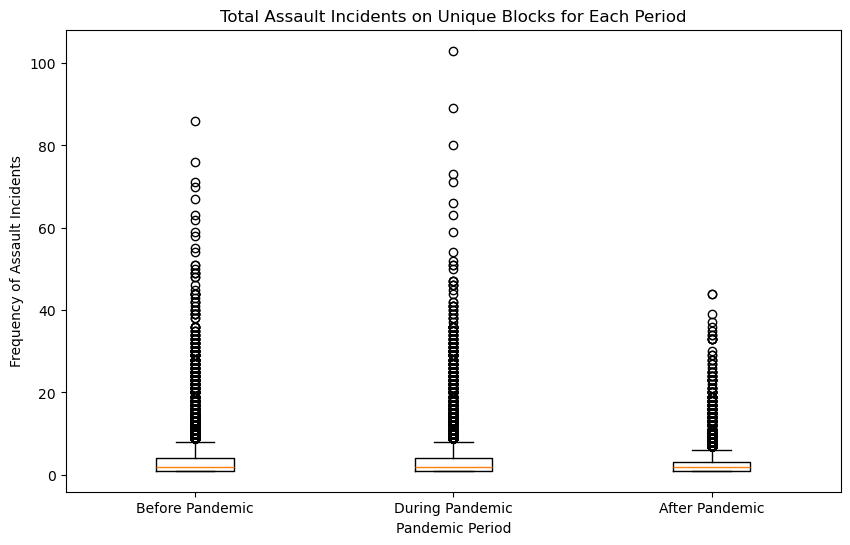

{'Before Pandemic': 8.5, 'During Pandemic': 8.5, 'After Pandemic': 6.0}


In [35]:
# Make a chart with 3 boxplots, one for each period that was calculated above
fig, ax = plt.subplots(figsize=(10,6)) # Alter figsize if needed (width, height)
ax.boxplot(all_incident_counts, tick_labels=period_order) # Sets up labels for chart

# Now set up formatting
ax.set_title(f"Total {specific_value.title()} Incidents on Unique Blocks for Each Period")
ax.set_xlabel(f"Pandemic Period")
ax.set_ylabel(f"Frequency of {specific_value.title()} Incidents")

# Display the Chart
plt.show()

# Finally, print out the outliers_dict to show the outlier values at the very bottom
print(outliers_dict)

In [36]:
# Check new that new outlier pandas DataFrames exist
print(Before_Pandemic_outliers_df.head(1))
print(During_Pandemic_outliers_df.head(1))
print(After_Pandemic_outliers_df.head(1))

                     Date Primary Type            Block   Latitude  Longitude  \
46309 2018-05-16 15:45:00      ASSAULT  020XX E 71ST ST  41.766248 -87.575623   

       Pandemic Period  
46309  Before Pandemic  
                    Date Primary Type               Block   Latitude  \
4795 2022-02-17 20:00:00      ASSAULT  071XX S HALSTED ST  41.764282   

      Longitude  Pandemic Period  
4795 -87.644389  During Pandemic  
                  Date Primary Type             Block   Latitude  Longitude  \
31 2023-11-10 11:00:00      ASSAULT  010XX W 103RD PL  41.705957 -87.648373   

   Pandemic Period  
31  After Pandemic  


#### Step 4: Get the outlier values of the new outlier dataframes 
Because these data points would be the outliers of the outliers, I think that we can define them as "**Hotspots**"

In [37]:
# This code follows the exact steps as the code above to find the outliers of the outlier dataframe, which is our definition of a hotspot
# The only things that changed are the varible names, the zipped loop, and we are referencing the new dataframes we created in the last step
# to remove the filtering step
outlier_dataframes = ['Before_Pandemic_outliers_df', 'During_Pandemic_outliers_df', 'After_Pandemic_outliers_df']

# Initialize a dictionary and list
outer_outlier_dict = {}
outer_outlier_incident_counts = []

# This zips the outlier_dataframes and period_order together. I did this because I wanted to be able to reference the period in this loop
# I tried a nested loop and that was outputting 9 different analysis. Thus, the zipped loop gets rid of that problem
for period_df, period in zip(outlier_dataframes, period_order):
    
    # Gets the current outlier dataframe and assign it to a new variable
    outer_outlier_df = globals().get(period_df)

    print(f"Analyzing data for {specific_value.lower()} incidents that occurred {period}\n")

    # Calculate the unique value counts for each block within this period-specific DataFrame
    outer_outlier_data = outer_outlier_df['Block'].value_counts()
    outer_outlier_incident_counts.append(outer_outlier_data.to_list())

    # Calculate the quartile values for plotting boxplots
    quartiles = outer_outlier_data.quantile([0.25, 0.5, 0.75, 1.0])
    lowerq = quartiles[0.25]  # Lower quartile
    upperq = quartiles[0.75]  # Upper quartile
    iqr = upperq - lowerq     # Interquartile range

    # Calculate bounds for outliers
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)

    # Print combined output for quartile calculations
    print(
        f"The lower quartile of {specific_value.lower()} incidents is: {lowerq}\n"
        f"The upper quartile of {specific_value.lower()} incidents is: {upperq}\n"
        f"The interquartile range of {specific_value.lower()} incidents is: {iqr}\n"
        f"Values below {lower_bound} could be outliers.\n"
    )

    # Print combined output for hotspot calculations
    print(
        f"\nIMPORTANT:\n"
        f"\nThis is the data that I think defines a 'Hotspot', which is going to be all values that are the outliers of the outliers.\n"
        f"Thus, blocks with incident count values above {upper_bound} are data points that we can now define as 'Hotspots'."
    )
    
    # Input hotspot value into a dictionary for each period
    outer_outlier_dict[period] = upper_bound

    # Filter period data to keep only rows where block counts are above the upper bound
    hotspot_blocks = outer_outlier_data[outer_outlier_data > upper_bound].index
    hotspots_df = outer_outlier_df[outer_outlier_df['Block'].isin(hotspot_blocks)]
    
    # Store the filtered DataFrame back into globals for further analysis if needed
    globals()[f"{period.replace(' ', '_')}_hotspots_df"] = hotspots_df

    print("=" * 75)  # Separator between different periods




Analyzing data for assault incidents that occurred Before Pandemic

The lower quartile of assault incidents is: 10.0
The upper quartile of assault incidents is: 16.0
The interquartile range of assault incidents is: 6.0
Values below 1.0 could be outliers.


IMPORTANT:

This is the data that I think defines a 'Hotspot', which is going to be all values that are the outliers of the outliers.
Thus, blocks with incident count values above 25.0 are data points that we can now define as 'Hotspots'.
Analyzing data for assault incidents that occurred During Pandemic

The lower quartile of assault incidents is: 10.0
The upper quartile of assault incidents is: 17.0
The interquartile range of assault incidents is: 7.0
Values below -0.5 could be outliers.


IMPORTANT:

This is the data that I think defines a 'Hotspot', which is going to be all values that are the outliers of the outliers.
Thus, blocks with incident count values above 27.5 are data points that we can now define as 'Hotspots'.
Analyzi

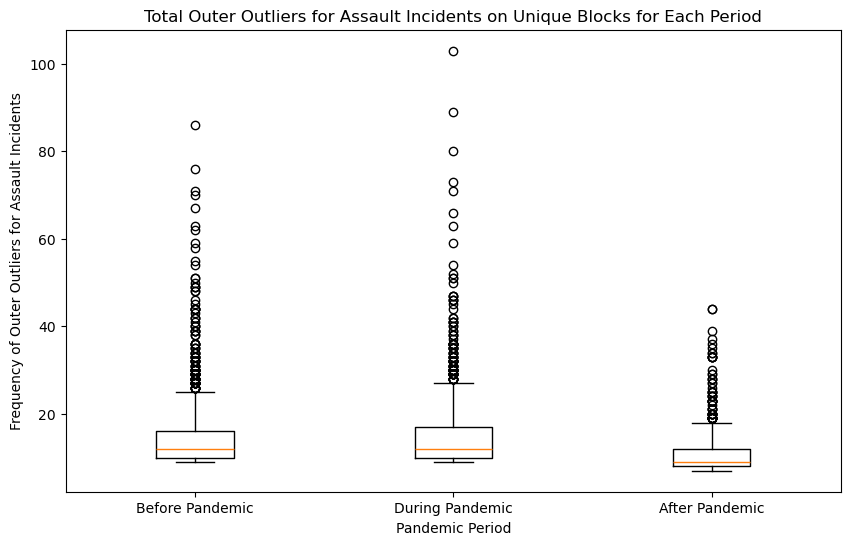

{'Before Pandemic': 25.0, 'During Pandemic': 27.5, 'After Pandemic': 18.0}


In [38]:
# Make a chart with 3 boxplots, one for each period that was calculated above
fig, ax = plt.subplots(figsize=(10,6)) # Alter figsize if needed (width, height)
ax.boxplot(outer_outlier_incident_counts, tick_labels=period_order) # Keeps labels consistent in both charts

# Now set up formatting
ax.set_title(f"Total Outer Outliers for {specific_value.title()} Incidents on Unique Blocks for Each Period")
ax.set_xlabel(f"Pandemic Period")
ax.set_ylabel(f"Frequency of Outer Outliers for {specific_value.title()} Incidents")

# Display the Chart
plt.show()

# Finally, print out the outliers_dict to show the outlier values at the very bottom
print(outer_outlier_dict)

In [39]:
# Check new that new hotspot pandas DataFrames exist
print(Before_Pandemic_hotspots_df.head(1))
print(During_Pandemic_hotspots_df.head(1))
print(After_Pandemic_hotspots_df.head(1))

                      Date Primary Type              Block   Latitude  \
302018 2018-08-18 18:00:00      ASSAULT  040XX W GRAND AVE  41.906432   

        Longitude  Pandemic Period  
302018 -87.727113  Before Pandemic  
                     Date Primary Type             Block  Latitude  Longitude  \
12802 2023-04-22 20:59:00      ASSAULT  065XX S LOWE AVE  41.77543 -87.640753   

       Pandemic Period  
12802  During Pandemic  
          Date Primary Type            Block   Latitude  Longitude  \
470 2023-09-07      ASSAULT  040XX W 26TH ST  41.844253 -87.724944   

    Pandemic Period  
470  After Pandemic  


#### Step 4: Plot the newly defined "**Hot Spots**"
Now that we have our hot spots defined it is time to plot them on charts

In [53]:
# Once again
# Initialize a list for to reference each new hotspot dataframe
hotspot_dfs = ['Before_Pandemic_hotspots_df', 'During_Pandemic_hotspots_df', 'After_Pandemic_hotspots_df']

# Loop through each period-specific outlier DataFrame to generate maps
for hotspot_df, period in zip(hotspot_dfs, period_order):
    
    # Get the current hotspot dataframe for plotting
    hotspot_data = globals().get(hotspot_df).copy()
    
    print(f"Mapping Chicago Hotspots for {specific_value.title()} Incidents {period}\n")

    # Calculate unique value counts for each 'Block' in this period-specific DataFrame
    hotspot_incident_count = hotspot_data['Block'].value_counts()

    # Merge the incident count with the original data based on 'Block'
    hotspot_data = hotspot_data.merge(hotspot_incident_count, left_on='Block', right_index=True, how='left')

    # Rename the resulting column to 'Block_Count' if necessary
    hotspot_data = hotspot_data.rename(columns={'count': 'Block Count'})

    # Calculate sizes based on unique counts for scaled visual effect
    hotspot_data['Point Size'] = hotspot_data['Block Count'] / hotspot_data['Block Count'].max()  # Ensure the scaling is done properly
    hotspot_data['Point Size'] = hotspot_data['Point Size'] * 100 # Increase the value if hotspots are not well displayed

    # Display map-based plot for Chicago hotspots with `hvplot.points`
    map_plot = hotspot_data.hvplot.points(
        'Longitude',
        'Latitude',
        geo=True,
        tiles='CartoLight',  # Enable map background
        color='blue', # Change Color
        alpha=0.3, # Change the transparency
        size='Point Size', # The more incidents that occur, the bigger the point on the map
        title=f"Chicago {specific_value.title()} Hotspots {period}", 
        xlabel="Longitude", 
        ylabel="Latitude", 
        frame_width=800, 
        frame_height=600,
        hover_cols=['Block', 'Block Count', 'Latitude', 'Longitude']
    )

    display(map_plot)  # hvplot.points uses display instead of plt.show()

    print('=' * 150)  # Separator between different charts



Mapping Chicago Hotspots for Assault Incidents Before Pandemic



:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Point Size,Block,Block Count)

Mapping Chicago Hotspots for Assault Incidents During Pandemic



:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Point Size,Block,Block Count)

Mapping Chicago Hotspots for Assault Incidents After Pandemic



:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Point Size,Block,Block Count)

In [28]:
print(hotspot_data.head())


                      Date Primary Type                Block   Latitude  \
302018 2018-08-18 18:00:00      ASSAULT    040XX W GRAND AVE  41.906432   
302075 2018-12-19 16:40:00      ASSAULT      002XX E 35TH ST  41.831073   
454330 2017-01-14 08:50:00      ASSAULT      003XX W 64TH ST  41.778099   
455086 2017-01-16 14:18:00      ASSAULT  0000X E RANDOLPH ST  41.884494   
457755 2017-01-26 21:05:00      ASSAULT     064XX S LOWE AVE  41.777310   

        Longitude  Pandemic Period  count  
302018 -87.727113  Before Pandemic     27  
302075 -87.620211  Before Pandemic     30  
454330 -87.633829  Before Pandemic     31  
455086 -87.627021  Before Pandemic     32  
457755 -87.640803  Before Pandemic     39  
